In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import stats
from scipy.stats import exponweib
from scipy.optimize import minimize
from scipy.misc import factorial
import scipy.optimize
import time

In [17]:
# Logan Herrera
# Stanford Student Space Initiative
# IREC 2017
#
# Takes NOAA IGRA all-time historical data files and cuts out all flights outside of the date range. 
# Possible sites are Albuquerque, New Mexico and Santa Teresa, New Mexico (very close to El Paso, Texas)
# Date range is currntly configured for 01 June to 31 July in the years 2000 to 2019.
#
# This cell should only be run once. The output files created are inputs for the cell that follows.
#
# https://www.ncdc.noaa.gov/data-access/weather-balloon/integrated-global-radiosonde-archive
# https://www1.ncdc.noaa.gov/pub/data/igra/data/data-por/
# https://www1.ncdc.noaa.gov/pub/data/igra/data/igra2-data-format.txt

any_header_pattern =    r'#USM0007236[45]\s[0-9]{4}\s[0-9]{2}\s[0-9]{2}'
target_header_pattern = r'#USM0007236[45]\s20[0-1][0-9]\s0[6-7]'    

#inputfile = 'USM00072364-ABQ-data.txt'        # Albuquerque
#outputfile = 'ABQ_IGRA_snippedoutput.txt'

inputfile = 'USM00072365-ST-data.txt'          # Santa Teresa
outputfile ='ST_IGRA_snippedoutput.txt'

any_header = re.compile(any_header_pattern)
target_header = re.compile(target_header_pattern)
f = open(inputfile,'r')
g = open(outputfile,'w')

data_block = False
for line in f:
    if not any_header.match(line) and data_block == True:
        g.write(line)    
    elif target_header.match(line):
        data_block = True
        g.write(line)        
    else:
        data_block = False
  
f.close()
g.close()
print('done!')

done!


In [4]:
def import_data (inputfile, max_alt):
    min_points = 5

    #inputfile = 'simplefile.txt'
    #inputfile = 'ST_IGRA_snippedoutput.txt'
    #inputfile = 'ABQ_IGRA_snippedoutput.txt'

    f = open(inputfile,'r')

    key = None
    data = dict()
    for line in f:
        if 'USM00072364' in line or 'USM00072365' in line:
            key = line[13:26]
            key = key.replace(' ','')
            data[key] = None
        else:
            line = line.replace('A',' ')           # delete non-numeric characters (spurious A's)
            line = line.replace('B',' ')           # delete non-numeric characters (spurious B's)
            line = line.split()                    # split data on white space
            latest_datum = np.array(list(map(float, line)))    # convert list of strings to list of floats
            if latest_datum[3] <= max_alt and latest_datum[4] and latest_datum[7] != -9999 and latest_datum[8] != -9999:
                latest_datum[8] = latest_datum[8] / 10
                if data[key] is None:
                    data[key] = latest_datum
                else:
                    data[key] = np.vstack((data[key], latest_datum))          # append new data below previous data in key-value pair

    # column 3 is GPH
    # column 7 is WDIR
    # column 8 is WSPD

    total_rejected = 0
    badkeys = []
    for b in data.keys():
        if data[b] is None or data[b].ndim == 1 or len(data[b]) <= min_points:
            total_rejected += 1     
            badkeys.append(b)

    for c in badkeys:        
        del data[c]

    print('Number of rejected balloon flights = ' + str(total_rejected))

    data_interp = dict()
    for a in data.keys():
        data_interp[a] = (interp1d(data[a][:,3], data[a][:,7],kind='linear',fill_value='extrapolate'), 
                          interp1d(data[a][:,3], data[a][:,8],kind='linear',fill_value='extrapolate'))

    f.close()
    
    year = np.arange(2000,2016+1,1)
    day = np.arange(1,61+1,1)
    alt = np.arange(1700,18100+100,100)
    speed = np.empty([len(year),len(day),2,len(alt)])
    heading = np.empty([len(year),len(day),2,len(alt)])
    min_valid_speed = 0        # round erroneously low values up to min_valid_speed
    max_valid_speed = 100      # round erroneously high values down to max_valid_speed

    for i in year:
        for j in day:
            for k in [0,1]:
                inputkey = str(i) + '0' + str(6 + j//31)
                if j % 31 < 10:
                    inputkey += '0'
                inputkey +=  str(j % 31)
                if k == 0:
                    inputkey += '00'
                else:
                    inputkey += '12'

                headingerrors = 0
                for h in range(0,len(alt)):
                    try:
                        heading[i-2000,j-1,k,h] = data_interp[inputkey][0](1700+h*100) % 360
                    except KeyError:
                        headingerrors +=1
                        heading[i-2000,j-1,k,h] = 0

                speederrors = 0
                for z in range(0,len(alt)):
                    try:
                        speed[i-2000,j-1,k,z] = min(max(data_interp[inputkey][1](1700+z*100), min_valid_speed), max_valid_speed)
                    except KeyError:
                        speederrors += 1
                        speed[i-2000,j-1,k,z] = 0

    print('Number of heading errors = ' + str(headingerrors))
    print('Number of speed errors = ' + str(speederrors))
    return [speed, heading]
    print('Done!')

In [5]:
ST_data = import_data('ST_IGRA_snippedoutput.txt', 60000*0.3048)
ABQ_data = import_data('ABQ_IGRA_snippedoutput.txt', 60000*0.3048)

FileNotFoundError: [Errno 2] No such file or directory: 'ST_IGRA_snippedoutput.txt'

In [2]:
ABQ_dist = 230.65    # ABQ is 230.65km from Spaceport America
ST_dist = 126.01     # ST is 126.01km from Spaceport America
total_dist = ABQ_dist + ST_dist
ABQ_weight = ST_dist/total_dist
ST_weight = ABQ_dist/total_dist

speed = ABQ_weight*ABQ_data[0] + ST_weight*ST_data[0]
circular_mean_ABQ_ST = circular_mean(ST_data[1], ABQ_data[1],(ST_weight,ABQ_weight))
heading_profile = np.empty(ABQ_data[1].shape[-1])
for i in range(0, ABQ_data[1].shape[-1]):
    heading_profile[i] = circular_mean(ABQ_data[1][:,:,:,i],ST_data[1][:,:,:,i],(ABQ_weight,ST_weight))
heading = np.empty(ABQ_data[1].shape)
for index in np.nindex(ABQ_data[1].shape):
    data[index] = circular_mean(ABQ_data[1][index],ST_data[1][index],(ABQ_weight,ST_weight))

NameError: name 'ABQ_data' is not defined

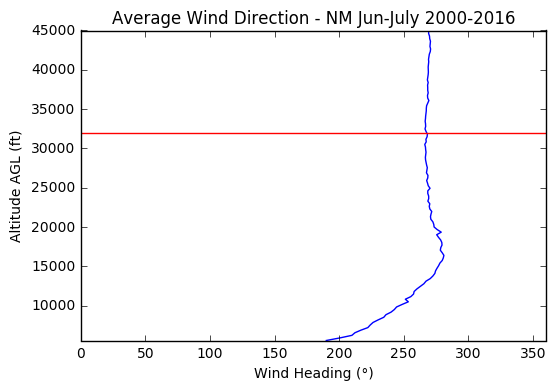

In [45]:
max_index = int((18100 - 1700)//100 + 1)

alt = np.arange(1700,18100+100,100)
plt.plot(heading_profile, alt*3.28084, '-')
plt.axhline(32000,color='r')
plt.xlabel('Wind Heading (°)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Average Wind Direction - NM Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 360)
plt.show()

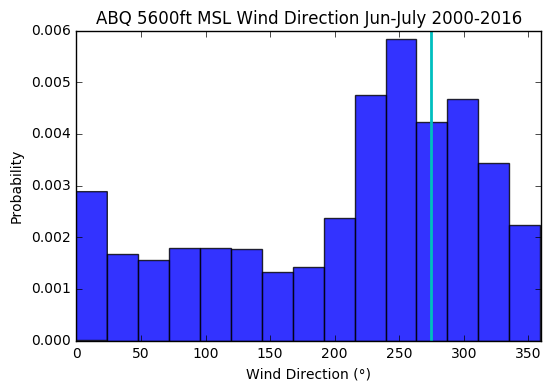

In [46]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
data = np.ravel(ST_data[1][:,:,:,30])

plt.hist(data,bins='auto',alpha=0.8,normed=True,color='b')
plt.xlim(0,360)
plt.xlabel('Wind Direction (°)')
plt.ylabel('Probability')
plt.title('ABQ 5600ft MSL Wind Direction Jun-July 2000-2016')
plt.axvline(circular_mean(data, data, (0.5,0.5)),color='c',lw=2)
plt.show()

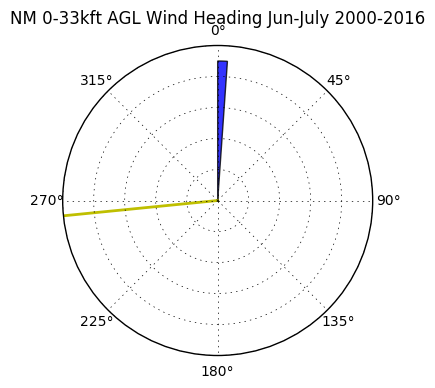

In [47]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
prob, theta, _ = plt.hist(np.ravel(heading[:][:][:][0:max_index]), bins=90, normed=True)

theta = np.deg2rad(theta[:-1])
prob[0] = 0.0001        # override probability of heading = 0 to 0.001. Produces excessive spike otherwise.
                        # more correct solution is to remove all entries with heading of exactly zero from dataset
max_height = np.max(prob)*1.1

mean_theta = (np.deg2rad(circular_mean_ABQ_ST),np.deg2rad(circular_mean_ABQ_ST))
mean_radial = (0, max_height)

width = (2*np.pi) / len(theta)
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, prob, width=width, alpha=0.8)
ax.plot(mean_theta, mean_radial, color='y', lw=2)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.axes.get_yaxis().set_ticklabels([])
ax.set_title('NM 0-33kft AGL Wind Heading Jun-July 2000-2016')
plt.show()

0.005 seconds to compute
Most likely wind speed is 4.071 m/s
Two sigma wind speed interval is (1.6047443755435591, 10.620073940523486) m/s


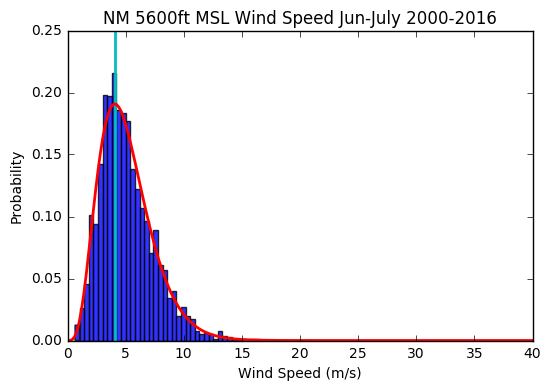

In [6]:
max_v = 40
max_index = int((33000*0.3048 - 1700)//100 + 1)
data = np.ravel(speed[:,:,:,0])
data = np.array(list(filter(lambda x: x<max_v and x>0, list(data))))

t0 = time.time()
p = stats.gamma.fit(data, floc=0)
greatest_prob = scipy.optimize.fmin(lambda x: -scipy.stats.gamma.pdf(x, *p), 5, disp=False)
two_sigma_interval = stats.gamma.interval(0.9544, p[0], loc=0, scale=p[2])
t1 = time.time()
print(str(round(t1-t0,4)) + ' seconds to compute')

X = np.linspace(0, max_v, 200)
plt.hist(data,bins=int(max_v),alpha=0.8,normed=True,color='b')
plt.axvline(greatest_prob,color='c',lw=2)
plt.plot(X, scipy.stats.gamma.pdf(X, *p),color='r',lw=2)
plt.xlim(0,max_v)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.title('NM 5600ft MSL Wind Speed Jun-July 2000-2016')

print('Most likely wind speed is ' + str(round(greatest_prob[0],3)) + ' m/s')
print('Two sigma wind speed interval is ' + str(two_sigma_interval) + ' m/s')
plt.show()

0.9686 seconds to compute


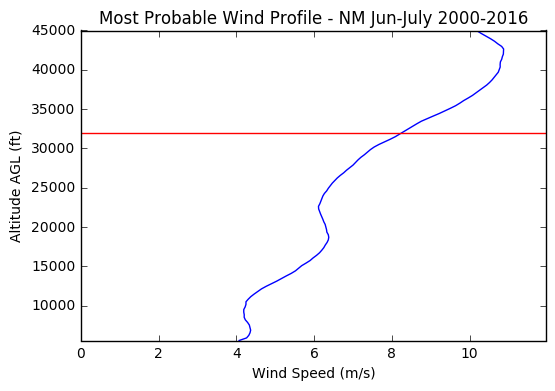

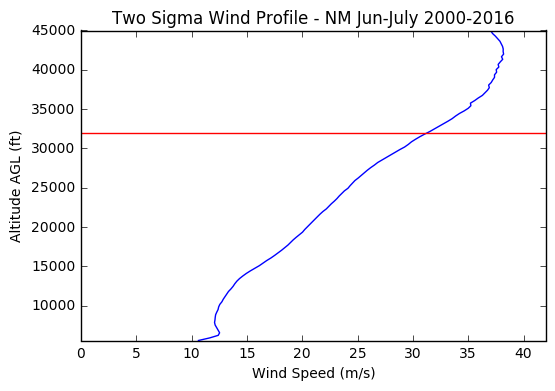

In [7]:
#max_index = int((33000*0.3048 - 1700)//100 + 1)
max_index = int((18100 - 1700)//100 + 1)

params = np.zeros((4,max_index))

t0 = time.time()
for q in np.arange(0,max_index,1):
    data = np.ravel(speed[:,:,:,q])
    data = np.array(list(filter(lambda x: x<max_v and x>0, list(data))))
    p = stats.gamma.fit(data, floc=0)
    params[1][q] = scipy.optimize.fmin(lambda x: -scipy.stats.gamma.pdf(x, *p), 5, disp=False)
    params[2][q] = stats.gamma.interval(0.9544, p[0], loc=0, scale=p[2])[1]
t1 = time.time()
print(str(round(t1-t0,4)) + ' seconds to compute')

alt = np.arange(1700,18100+100,100)
plt.plot(params[1,:], alt*3.28084, '-')
plt.axhline(32000,color='r')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Most Probable Wind Profile - NM Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(params[1,:]))
plt.show()

alt = np.arange(1700,18100+100,100)
plt.plot(params[2,:], alt*3.28084, '-')
plt.axhline(32000,color='r')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Two Sigma Wind Profile - NM Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(params[2,:]))
plt.show()

In [48]:
header = ('SSI IREC 2017\n'
          'NOAA IGRA derived high altitude winds\n'
          'Weighted average of Albuquerque, NM and Santa Teresa, NM.\n'
          'Limited to months of June and July in years 2000 to 2016.\n')
units =   'Altitude AGL (m), Wind Speed (m/s)'

sigma_str='This is the most probable velocity profile.\n'
filename = 'NM_mostprobablewindprofile.txt'
np.savetxt(filename, np.column_stack((alt,params[1,:])), header=header+sigma_str+units, \
           fmt=['%d','%1.3f'], delimiter=',', newline=',\n')

sigma_str='This is the two sigma worst case velocity profile.\n'
filename = 'NM_twosigmawindprofile.txt'
np.savetxt(filename, np.column_stack((alt,params[2,:])), header=header+sigma_str+units, \
           fmt=['%d','%1.3f'], delimiter=',', newline=',\n')

sigma_str='This is the average wind direction.\n'
filename = 'NM_averagewinddirection.txt'
# add heading data
np.savetxt(filename, np.column_stack((alt,heading_profile)), header=header+sigma_str+units, \
           fmt=['%d','%1.3f'], delimiter=',', newline=',\n')

NameError: name 'params' is not defined